
<a id='parallel'></a>
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Horse Race: Julia vs Fortran vs Python

**John Stachurski** September 2023

This notebook runs some simple execution speed comparisons for Julia, Python and FORTRAN.

These comparisons should be viewed as the basis of a conversation, not a serious scientific study.

The main messages are that 

1. all can be fast and 
2. for complex tasks, the ecosystem matters.

In [1]:
# for plots
import numpy as np
import matplotlib.pyplot as plt

# JIT compiler
import numba

## Problem Statement

Consider the time series model

$$ x_{t+1} = \alpha x_t (1 - x_t) $$


Our aim is to generate time series from this model and analyze them.

Throughout we set $\alpha = 4$

In [2]:
α = 4

Here's a typical time series:

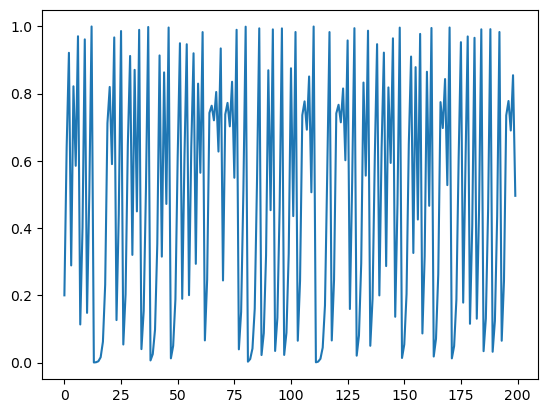

In [3]:
n = 200
x =  np.empty(n)
x[0] = 0.2
for t in range(n-1):
    x[t+1] = α * x[t] * (1 - x[t])
    
plt.plot(x)
plt.show()

## Pure Python --- Interpreted language speed test

Here's a function that iterates forward `n` times, starting from `x0`, and
returns **the final** value:

In [4]:
def quad(x0, n=10_000_000, α=4.0):
    x = x0
    for i in range(n):
        x = α * x * (1 - x)
    return x

Let's see how fast this runs:

In [5]:
%%time
x = quad(0.2)

CPU times: user 550 ms, sys: 751 µs, total: 551 ms
Wall time: 550 ms


## Fortran Test

Now let's try this in Fortran.

Note --- this step is intended to be a demo and will only execute if

* you have a Fortran compiler installed (on Ubuntu, sudo apt install gfortran) and 
* the compilation code below is modified to match your compiler 

In [6]:
%%file fortran_quad.f90

PURE FUNCTION QUAD(X0, N)
 IMPLICIT NONE
 INTEGER, PARAMETER :: DP=KIND(0.d0)                           
 REAL(dp), INTENT(IN) :: X0
 REAL(dp) :: QUAD
 INTEGER :: I
 INTEGER, INTENT(IN) :: N
 QUAD = X0
 DO I = 1, N - 1                                                
  QUAD = 4.0_dp * QUAD * real(1.0_dp - QUAD, dp)
 END DO
 RETURN
END FUNCTION QUAD

PROGRAM MAIN
 IMPLICIT NONE
 INTEGER, PARAMETER :: DP=KIND(0.d0)                          
 REAL(dp) :: START, FINISH, X, QUAD
 INTEGER :: N
 N = 10000000
 X = QUAD(0.2_dp, 10)
 CALL CPU_TIME(START)
 X = QUAD(0.2_dp, N)
 CALL CPU_TIME(FINISH)
 PRINT *,'last val = ', X
 PRINT *,'Elapsed time in milliseconds = ', (FINISH-START) * 1000
END PROGRAM MAIN

Writing fortran_quad.f90


In [7]:
!gfortran -O3 fortran_quad.f90

In [8]:
!./a.out

 last val =   0.46200166384322749     
 Elapsed time in milliseconds =    47.868999999999993     


Tidy up

In [9]:
!rm a.out
!rm fortran_quad.f90

## Julia Test

In [10]:
%%file julia_quad.jl

using BenchmarkTools

const α = 4.0

function quad(x0, n=10_000_000)
    x = x0
    for i in 1:(n-1)
        x = α * x * (1 - x)
    end
    return x
end

println(@btime quad(0.2))

Overwriting julia_quad.jl


The execution step below will seem slow because `@btime` runs the program many times, but the function runtime is fast.

In [11]:
!julia julia_quad.jl

  41.159 ms (0 allocations: 0 bytes)
0.4620016638432275


In [12]:
# clean up
!rm julia_quad.jl

## Python + Numba Test


Now let's replicate the calculations using Numba's JIT compiler.

Here's the Python function we want to speed up

In [13]:
quad = numba.jit(quad, nopython=True)

This is the same as before except that we've targeted the function for JIT
compilation with `@numba.jit`.

Let's see how fast it runs.

In [14]:
%%time
x = quad(0.2)

CPU times: user 277 ms, sys: 40.2 ms, total: 317 ms
Wall time: 315 ms


In [15]:
%%timeit
x = quad(0.2)

41.1 ms ± 14.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Exercise

Modify the model so that

$$
    X_{t+1} = \alpha X_t (1 - X_t)U_{t+1}
$$

where $(U_t)$ is IID and uniform on $(0,1)$.

Compare execution speeds for generating time series using Julia and Python + Numba when the parameters and time series length are otherwise identical to the experiment above.

In [16]:
for _ in range(20):
    print("Solution below")

Solution below
Solution below
Solution below
Solution below
Solution below
Solution below
Solution below
Solution below
Solution below
Solution below
Solution below
Solution below
Solution below
Solution below
Solution below
Solution below
Solution below
Solution below
Solution below
Solution below


Here's the Julia version.

In [17]:
%%file julia_quad.jl

using BenchmarkTools

const α = 4.0

function quad(x0, n=10_000_000)
    x = x0
    for i in 1:(n-1)
        x = α * x * (1 - x) * rand()
    end
    return x
end

println(@btime quad(0.2))

Writing julia_quad.jl


In [18]:
!julia julia_quad.jl

  59.245 ms (0 allocations: 0 bytes)
0.04457237980786439


Here's the Python-Numba version.

In [24]:
from numpy.random import rand

@numba.jit(nopython=True)
def quad(x0, n=10_000_000):
    x = x0
    for i in range(1, n):
        x = α * x * (1 - x) * rand()
    return x

With compile time:

In [25]:
%%time
quad(0.2)

CPU times: user 171 ms, sys: 76 µs, total: 171 ms
Wall time: 170 ms


0.0021515033501767816

Without compile time:

In [26]:
%%timeit
quad(0.2)

66.3 ms ± 50.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
